# Predicting customer lifetime value using machine learning
---
### Problem Statement: Can we build an accurate model to predict next 6 month LTV at customer level?
---
### Table of Contents:
1. Load datasets, packages, and parameters
2. Customer Exploratory Analysis
3. Transactions Exploratory Analysis
4. Response Variable Creation
5. Feature Engineering
6. Model Training
7. Model Evaluation
8. Closing Summary and Recommendations
---

## 1. Load Raw Data Sets and Parameters

In [1]:
%reload_kedro
from process.pipelines.data_processing import nodes as dp
from process.pipelines.data_science import nodes as ds
import matplotlib.pyplot as plt
from sklearn import preprocessing
# Run help(dp) or help(ds) for documentation on functions

2021-12-05 16:12:43,413 - kedro.framework.session.store - INFO - `read()` not implemented for `BaseSessionStore`. Assuming empty store.
2021-12-05 16:12:43,435 - root - INFO - ** Kedro project LTV Model
2021-12-05 16:12:43,436 - root - INFO - Defined global variable `context`, `session` and `catalog`
2021-12-05 16:12:43,449 - root - INFO - Registered line magic `run_viz`


In [49]:
customers = catalog.load('customers').set_index('customer_id')
transactions = catalog.load('transactions')

2021-12-05 17:36:00,420 - kedro.io.data_catalog - INFO - Loading data from `customers` (CSVDataSet)...
2021-12-05 17:36:00,864 - kedro.io.data_catalog - INFO - Loading data from `transactions` (CSVDataSet)...


## 2. Customer Exporatory Analysis

In [3]:
customers.head()

,state,age,gender,income,is_married,promo_group_1,promo_group_2,customer_loyalty_index,brand_awareness_index
customer_id,,,,,,,,,
0,NJ,64,Female,65000.0,Y,A,X,0.058849,1.969644e-01
1,NY,26,Female,43000.0,Y,A,Z,-4.872865,2.970386e-14
2,NH,55,Female,93000.0,Y,C,X,NaN,NaN
3,ME,18,Female,68000.0,N,B,Z,0.152339,2.341961e-03
4,CA,41,Female,25000.0,N,A,Y,0.732875,8.073341e-14


Female    0.49809
Male      0.29921
Other     0.20270
Name: gender, dtype: float64


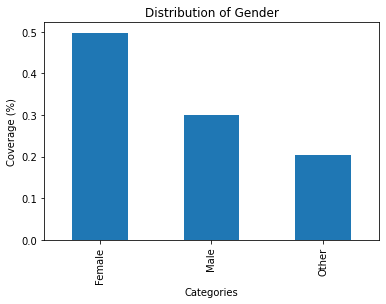

In [4]:
ax = customers.gender.value_counts(normalize = True).plot.bar()
ax.set_title("Distribution of Gender")
ax.set_xlabel("Categories")
ax.set_ylabel("Coverage (%)")
print(customers.gender.value_counts(normalize = True))

__The majority of customers are female (49%).__

N    0.56061
Y    0.43939
Name: is_married, dtype: float64


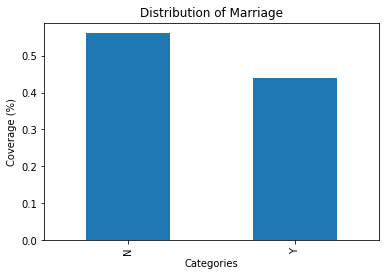

In [5]:
ax = customers.is_married.value_counts(normalize = True).plot.bar()
ax.set_title("Distribution of Marriage")
ax.set_xlabel("Categories")
ax.set_ylabel("Coverage (%)")
print(customers.is_married.value_counts(normalize = True))

__The majority of customers are not married (56%).__

In [6]:
customers[['gender','is_married']].value_counts()

gender  is_married
Female  N             28024
        Y             21785
Male    N             16627
        Y             13294
Other   N             11410
        Y              8860
dtype: int64

__The marriage rate is roughly the same between males and females, but not other.__

TX    0.113060
CA    0.112743
NJ    0.111744
NY    0.111427
GA    0.110934
NH    0.110534
FL    0.109935
ME    0.109911
MA    0.109712
Name: state, dtype: float64


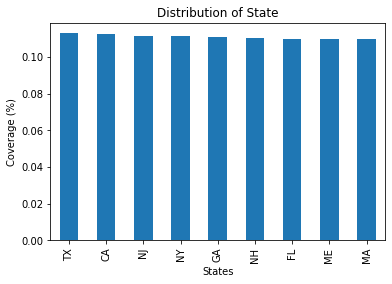

In [7]:
ax = customers.state.value_counts(normalize = True).plot.bar()
ax.set_title("Distribution of State")
ax.set_xlabel("States")
ax.set_ylabel("Coverage (%)")
print(customers.state.value_counts(normalize = True))

__We have 9 distinct states that are evenly distributed.__

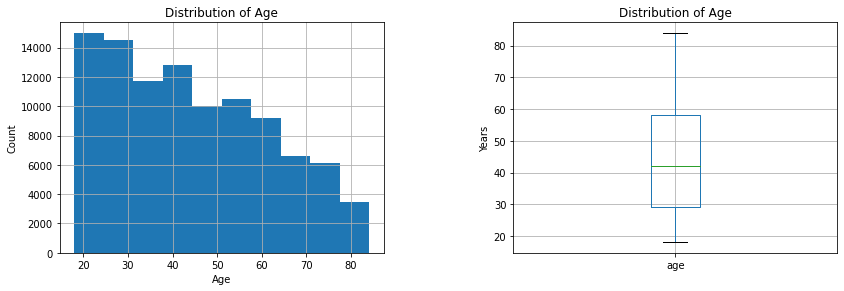

In [8]:
plt.subplot(1, 2, 1)
ax = customers.age.hist()
ax.set_title("Distribution of Age")
ax.set_xlabel("Age")
ax.set_ylabel("Count")

plt.subplot(1, 2, 2)
ax = customers.boxplot(column='age')
ax.set_title("Distribution of Age")
ax.set_ylabel("Years")                    

plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=1.9, 
                    top=0.9, 
                    wspace=0.4, 
                    hspace=0.4)

plt.show()

__Bottom half of customer population are between 18 and 42 (difference of 24 years), the top half are between 43 and 84 (difference 41 years)__

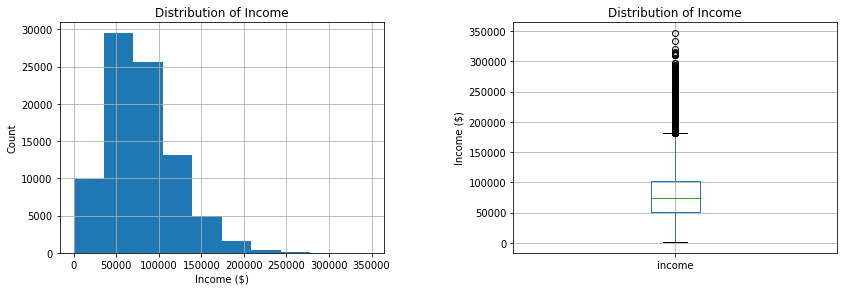

In [9]:
plt.subplot(1, 2, 1)
ax = customers.income.hist()
ax.set_title("Distribution of Income")
ax.set_xlabel("Income ($)")
ax.set_ylabel("Count")

plt.subplot(1, 2, 2)
ax = customers.boxplot(column='income')
ax.set_title("Distribution of Income")
ax.set_ylabel("Income ($)")                   

plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=1.9, 
                    top=0.9, 
                    wspace=0.4, 
                    hspace=0.4)

plt.show()

__Bottom half of customer population earn less than $74,000/annually__

Text(0, 0.5, 'Count')

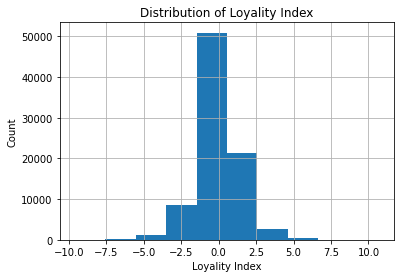

In [10]:
ax = customers.customer_loyalty_index.hist()
ax.set_title("Distribution of Loyality Index")
ax.set_xlabel("Loyality Index")
ax.set_ylabel("Count")

__Customer loyalty index appears to be normally distributed around 0.__

Text(0, 0.5, 'Count')

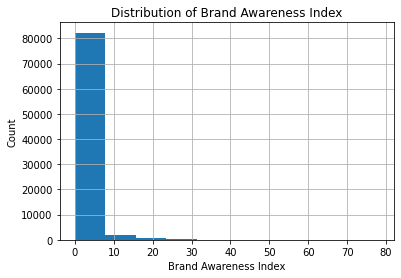

In [11]:
ax = customers.brand_awareness_index.hist()
ax.set_title("Distribution of Brand Awareness Index")
ax.set_xlabel("Brand Awareness Index")
ax.set_ylabel("Count")

__Brand Awareness has major postive skewness__

          income       age
income  1.000000  0.004502
age     0.004502  1.000000


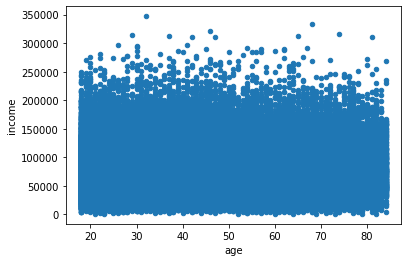

In [12]:
customers.plot.scatter(y = 'income', x = 'age')
print(customers[['income','age']].corr())

__There isn't a linear relationship between age and income__

---
__In fact, the continuous variables don't have any linear relationships.__

In [36]:
customers[['income','age','customer_loyalty_index','brand_awareness_index']].corr()

,income,age,customer_loyalty_index,brand_awareness_index
income,1.000000,0.004502,0.001694,-0.003763
age,0.004502,1.000000,0.002308,-0.000759
customer_loyalty_index,0.001694,0.002308,1.000000,-0.002624
brand_awareness_index,-0.003763,-0.000759,-0.002624,1.000000


---

#### Customer EDA Recap:
- 49% of customers are female, 29% are male, and 20% other
- 56% of customers are not married.
- Customers are only located in Texas, California, New Jersey, New York, and Georgia (evenly distributed)
- 50% of customers are under the age of 42
- 50% of customers have an annual income of $74,000
- No linear relationship between income and age
- No linear relationships between income, age, customer_loyalty, brand_awareness
- We will need to Label encode the categorical variables.
- We will need to apply Standard scale for our continuous variables.
    - We will need to apply mean imputation for nan values.
---

## 3. Transactions Exporatory Analysis

In [14]:
transactions.head()

,customer_id,transaction_value,transaction_days_after_joining
0,0,5.0,1.0
1,0,2.0,16.0
2,0,10.0,31.0
3,0,8.0,46.0
4,0,9.0,61.0


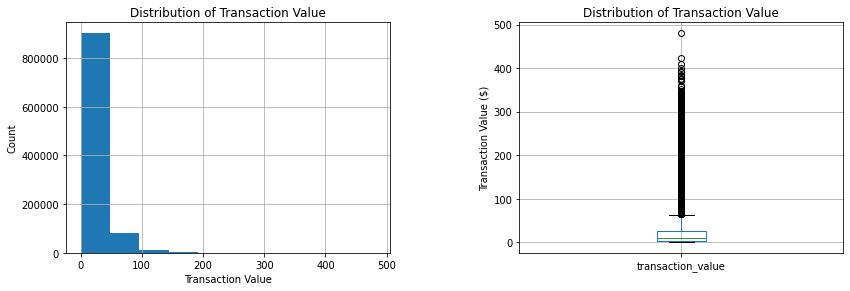

In [15]:
plt.subplot(1, 2, 1)
ax = transactions.transaction_value.hist()
ax.set_title("Distribution of Transaction Value")
ax.set_xlabel("Transaction Value")
ax.set_ylabel("Count")

plt.subplot(1, 2, 2)
ax = transactions.boxplot(column='transaction_value')
ax.set_title("Distribution of Transaction Value")
ax.set_ylabel("Transaction Value ($)")                   

plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=1.9, 
                    top=0.9, 
                    wspace=0.4, 
                    hspace=0.4)

plt.show()

__Bottom 50% of transaction value is between 0.00 and 11.00 dollars. Said another way, 50% of transactions are less than 11 dollars.__

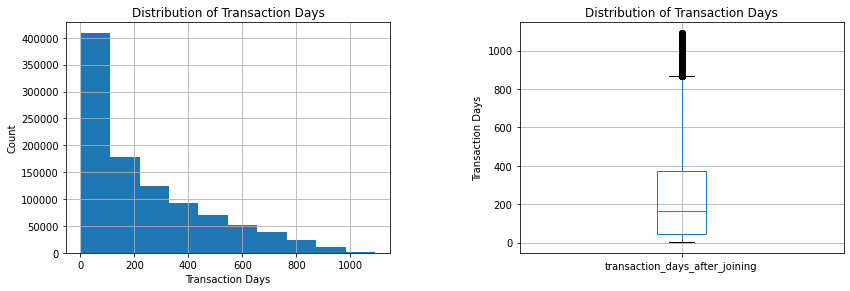

In [145]:
plt.subplot(1, 2, 1)
ax = transactions.transaction_days_after_joining.hist()
ax.set_title("Distribution of Transaction Days")
ax.set_xlabel("Transaction Days")
ax.set_ylabel("Count")

plt.subplot(1, 2, 2)
ax = transactions.boxplot(column='transaction_days_after_joining')
ax.set_title("Distribution of Transaction Days")
ax.set_ylabel("Transaction Days")                   

plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=1.9, 
                    top=0.9, 
                    wspace=0.4, 
                    hspace=0.4)

plt.show()

__50% of transaction are within 5 1/2 months after first transaction.__

Text(0, 0.5, 'Count')

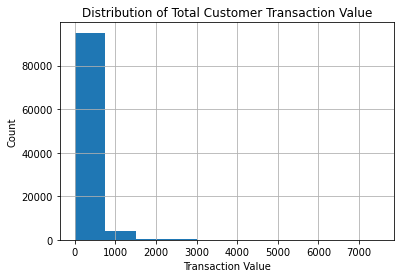

In [17]:
ax = transactions.groupby('customer_id').transaction_value.sum().hist()
ax.set_title("Distribution of Total Customer Transaction Value")
ax.set_xlabel("Transaction Value")
ax.set_ylabel("Count")                 

__50% of total customer spend is less than $89.__

---

#### Transaction EDA Recap:
- 50% of transactions occur within 5 1/2 months after first transaction
- 50% of customer total transaction value is 89 dollars.
- 50% of transactions are less than 11 dollars.
- Clear evidence of positive skewness in transaction value and transaction days.
---

## 3. Response Variable Creation

* As a reminder, our goal is to predict customer lifetime value. Customer lifetime value is next 6 month LTV.
* We define next 6 month LTV has the rolling 6 month sum of transaction value.
---
Lets go through an example. Here is the total cumulative sum of transaction value for customer_0.

<AxesSubplot:>

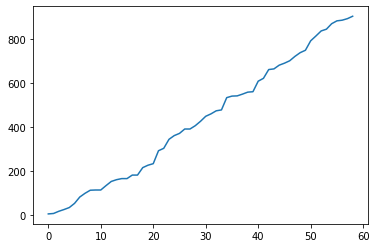

In [25]:
transactions[transactions['customer_id'] == 0]['transaction_value'].cumsum().plot()

After 866 days from the initial purchase, customer_0 has a total lifetime value of $906.

---

We can break up the cumulative sum by 180 days:

In [31]:
#Column for 180 days (6 months)
transactions['rolling_6_months'] = (
    (transactions['transaction_days_after_joining']-1) / 180).astype(int)

transactions['rolling_6_month_ltv'] = transactions.groupby(
    ['customer_id', 'rolling_6_months'])['transaction_value'].cumsum()

Text(0, 0.5, 'Transaction value ($)')

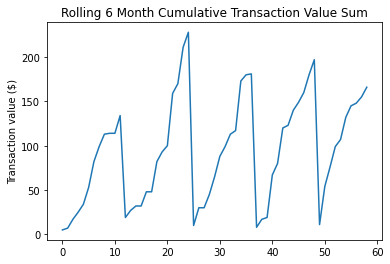

In [34]:
ax = transactions[transactions['customer_id'] == 0]['rolling_6_month_ltv'].plot()
ax.set_title("Rolling 6 Month Cumulative Transaction Value Sum")
ax.set_ylabel("Transaction value ($)")

The peaks tell us the total transaction value within a rolling 180 day period. We will use the peaks as the response variables, because our goal is to predict the next 6 month ltv. Therefore we want to learn from the historical 6 month total ltv for each customer. 

---

Our response variable is the rolling 180 day cumulative transaction value for each customer (rolling_6_month_ltv)

In [47]:
rolling_ltv = dp.target_variable(transactions)
rolling_ltv.head()

,rolling_6_months,rolling_6_month_ltv
customer_id,,
0,0,134.0
0,1,228.0
0,2,181.0
0,3,197.0
0,4,166.0


In [67]:
#Build our repsonse variable for the feature table
response = dp.target_variable(transactions).drop('rolling_6_months', axis = 1)

---

## 3. Feature Engineering

We will use a feature engineering map to provide standard scaler and label encoding on the customers table. The map is shown below which is loaded via the parameters.yml file.

In [52]:
parameters = catalog.load('parameters')
parameters['feature_engineering_map']

2021-12-05 17:36:43,470 - kedro.io.data_catalog - INFO - Loading data from `parameters` (MemoryDataSet)...


{'state': 'label',
 'gender': 'label',
 'is_married': 'label',
 'promo_group_1': 'label',
 'promo_group_2': 'label',
 'age': 'continuous',
 'income': 'continuous',
 'customer_loyalty_index': 'continuous',
 'brand_awareness_index': 'continuous'}

In [69]:
cont_features = dp.continuous_variables(customers, parameters)
help(dp.continuous_variables)

cat_features, label_mapping = dp.categorical_variables(customers, parameters)
help(dp.categorical_variables)

Help on function continuous_variables in module process.pipelines.data_processing.nodes:

continuous_variables(df: pandas.core.frame.DataFrame, parameters: Dict) -> pandas.core.frame.DataFrame
    Scale continuous variables with mean imputation
    
    Args:
        df (pd.DataFrame): raw feature table
        parameters ([type], optional): dictionary of feature and type mapping.
    
    Returns:
        Tuple: scaled dense feature table and scalar mapping

Help on function categorical_variables in module process.pipelines.data_processing.nodes:

categorical_variables(df: pandas.core.frame.DataFrame, parameters: Dict) -> Tuple
    Convert categorical variables to continuous variables
    
    Args:
        df (pd.DataFrame): dense raw features
        parameters ([type], optional): dictionary of feature and type mapping. Defaults to None.
    
    Returns:
        Tuple: categorical features and label mapping



In [61]:
# We should be scaled with mean 0.
cont_features.head()

,age,income,customer_loyalty_index,brand_awareness_index
0,1.123826,-0.369170,0.039494,-0.253363
1,-1.045294,-0.919187,-3.448415,-0.316156
2,0.610087,0.330852,0.000000,0.000000
3,-1.501951,-0.294167,0.105614,-0.315410
4,-0.189062,-1.369201,0.516192,-0.316156


In [62]:
#We should have numbers instead of string values.
cat_features.head()

,state_label,gender_label,is_married_label,promo_group_1_label,promo_group_2_label
customer_id,,,,,
0,6,0,1,0,0
1,7,0,1,0,2
2,5,0,1,2,0
3,4,0,0,1,2
4,0,0,0,0,1


In [63]:
#We also have the mapping for the label encoding
label_mapping.head()

,input,output,attribute
0,CA,0,state
1,FL,1,state
2,GA,2,state
3,MA,3,state
4,ME,4,state


One last step in our feature table process is dropping variables with high multicollinearity (as measured with VIF).

To view logic for VIF please see (/src/process/pipelines/data_processing/nodes.py)

In [64]:
feature_table = dp.standardized_feature_table(response, cont_features, cat_features)

9


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   9 | elapsed:    2.1s remaining:    7.5s
[Parallel(n_jobs=-1)]: Done   4 out of   9 | elapsed:    2.2s remaining:    2.7s
[Parallel(n_jobs=-1)]: Done   6 out of   9 | elapsed:    2.3s remaining:    1.1s


Remaining variables:
[['state_label', 'gender_label', 'is_married_label', 'promo_group_1_label', 'promo_group_2_label', 'age', 'income', 'customer_loyalty_index', 'brand_awareness_index']]


[Parallel(n_jobs=-1)]: Done   9 out of   9 | elapsed:    2.5s finished


In [65]:
feature_table.head()

,rolling_6_month_ltv,state_label,gender_label,is_married_label,promo_group_1_label,promo_group_2_label,age,income,customer_loyalty_index,brand_awareness_index
0,134.0,6,0,1,0,0,1.123826,-0.36917,0.039494,-0.253363
0,228.0,6,0,1,0,0,1.123826,-0.36917,0.039494,-0.253363
0,181.0,6,0,1,0,0,1.123826,-0.36917,0.039494,-0.253363
0,197.0,6,0,1,0,0,1.123826,-0.36917,0.039494,-0.253363
0,166.0,6,0,1,0,0,1.123826,-0.36917,0.039494,-0.253363


## 6. Model Training

In [ ]:
First we will split our data into training and testing sets

In [66]:
help(ds._split_data)

Help on function _split_data in module process.pipelines.data_science.nodes:

_split_data(feature_table: pandas.core.frame.DataFrame, response: str) -> Tuple



In [ ]:
X_train, X_test, y_train, y_test = _split_data(feature_table, "6_mo_rolling_transaction_value")

The mean squared error (MSE) on test set: 9783.0927
Explained variance: 0.387


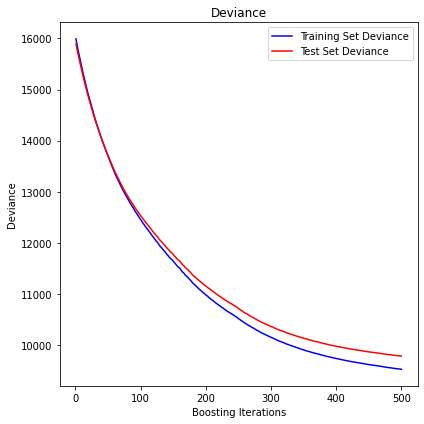

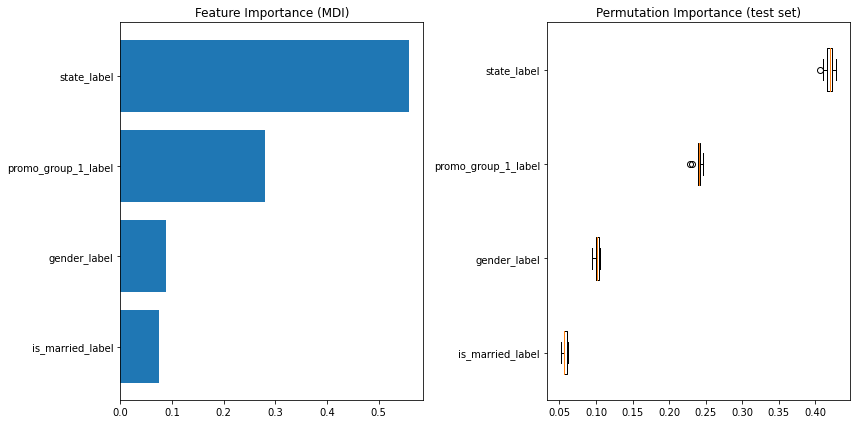

In [9]:
gradBoostReg = gradientBoostingRegressor(X_train, X_test, y_train, y_test)